In [45]:
# !pip install pydantic==2.7.0
# !pip install langchain
# !pip install langchain-openai
# !pip install tiktoken
# !pip install graphviz

In [46]:
# import os

# # Set OPENAI API Key

# os.environ["OPENAI_API_KEY"] = "your openai key"

# OR (load from .env file)
# make sure you have python-dotenv installed
# from dotenv import load_dotenv
# load_dotenv("./.env")



# Trying Out Different Learning Acronyms

## ADEPT

- A:= analogy
- D:= diagram
- E:= example
- P:= plain english
- T:= technical definition

> This still needs a bridge into what the person cares about. So teachiing some formalization technique or trick to bring that person's interests into the problem/concept

In [47]:
from langchain.utils.openai_functions import convert_pydantic_to_openai_function
from langchain.schema.runnable import RunnableLambda
from langchain_core.prompts import ChatPromptTemplate
from langchain.schema.runnable import RunnableParallel
from langchain_openai import ChatOpenAI

def chain_analogy(llm): 
    return ChatPromptTemplate.from_template("Write a simple analogy for this concept: '''{concept}''', which should perfectly encapsulate\
        what it is.") | llm

def chain_diagram(llm):
    return ChatPromptTemplate.from_template("Write a knowledge graph with the necessary concepts and elements to understand the following concept: '''{concept}''', this diagram should perfectly encapsulate\
        what it is and what it relates to.") | llm

def chain_example(llm):
    return ChatPromptTemplate.from_template("Write down five examples that perfectly demonstrate this concept: '''{concept}'''. ") | llm


def chain_plain_english(llm):
    return ChatPromptTemplate.from_template("Write a plain english definition for this concept: '''{concept}'''") | llm


def chain_technical_definition(llm):
    return ChatPromptTemplate.from_template("Write a short and precise technical definition for this concept: '''{concept}'''") | llm


llm_chat = ChatOpenAI()

analogy_chain = chain_analogy(llm_chat)
diagram_chain = chain_diagram(llm_chat)
example_chain = chain_example(llm_chat)
plain_english_chain = chain_plain_english(llm_chat)
technical_definition_chain = chain_technical_definition(llm_chat)


concept = "joint probability mass function"
map_chain = RunnableParallel(analogy=analogy_chain, diagram=diagram_chain, example=example_chain, 
                             plain_english=plain_english_chain, technical_def=technical_definition_chain)
output_explanation = map_chain.invoke({"concept": concept})
output_explanation

{'analogy': AIMessage(content='A joint probability mass function is like a recipe that shows the likelihood of two ingredients coming together to create a specific dish.', response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 32, 'total_tokens': 56}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_c2295e73ad', 'finish_reason': 'stop', 'logprobs': None}, id='run-0241bccf-61be-473e-b363-6314f3946405-0'),
 'diagram': AIMessage(content='Joint Probability Mass Function:\n- Definition: A function that gives the probability that two discrete random variables X and Y take on specific values x and y\n- Related Concepts:\n  - Marginal probability mass function: The probability distribution of a single random variable from a joint probability distribution\n  - Conditional probability mass function: The probability of one random variable given the value of another random variable\n  - Independence: When two random variables are independent, their joint probability m

In [48]:
from IPython.display import Markdown, display


for key in output_explanation.keys():
    display(Markdown(f"**{key}**\n\n{output_explanation[key].content}\n\n"))

**analogy**

A joint probability mass function is like a recipe that shows the likelihood of two ingredients coming together to create a specific dish.



**diagram**

Joint Probability Mass Function:
- Definition: A function that gives the probability that two discrete random variables X and Y take on specific values x and y
- Related Concepts:
  - Marginal probability mass function: The probability distribution of a single random variable from a joint probability distribution
  - Conditional probability mass function: The probability of one random variable given the value of another random variable
  - Independence: When two random variables are independent, their joint probability mass function can be expressed as the product of their marginal probability mass functions
- Example: If X represents the number of heads in two coin flips and Y represents the number of tails, the joint probability mass function would give the probability of getting 0 heads and 2 tails, 1 head and 1 tail, or 2 heads and 0 tails.



**example**

1. Rolling two dice and calculating the probability of getting a sum of 7.
2. Flipping two coins and calculating the probability of getting one head and one tail.
3. Choosing a card from a standard deck of cards and then choosing a second card, calculating the probability of both cards being red.
4. Selecting two random numbers between 1 and 10 and calculating the probability that both numbers are even.
5. Drawing two marbles from a bag containing red and blue marbles and calculating the probability of drawing one of each color.



**plain_english**

A joint probability mass function is a mathematical function that gives the probability of two or more discrete random variables occurring together in a specific combination.



**technical_def**

A joint probability mass function is a mathematical function that assigns probabilities to each possible combination of outcomes for two or more random variables in a discrete probability distribution.



Ok, this is nice but can we make it better? Like the knowledge graph is not visual, how can we improve upon that? 

In [49]:
# from pydantic import BaseModel, Field
from langchain.pydantic_v1 import BaseModel, Field
from typing import List
from graphviz import Digraph
import argparse
from langchain.output_parsers import PydanticOutputParser
import graphviz
from IPython.display import display

class Node(BaseModel):
    id: int
    label: str
    color: str

class Edge(BaseModel):
    source: int
    target: int
    label: str
    color: str = "black"

class KnowledgeGraph(BaseModel):
    """A knowledge graph is a graph that represents knowledge as a set of entities and relations between them."""
    nodes: List[Node] = Field(..., description="A list of nodes in the knowledge graph")
    edges: List[Edge] = Field(..., description="A list of edges in the knowledge graph")


def visualize_knowledge_graph(kg: KnowledgeGraph):
    dot = Digraph(comment="Knowledge Graph")

    # Add nodes
    for node in kg.nodes:
        dot.node(str(node.id), node.label, color=node.color)

    # Add edges
    for edge in kg.edges:
        dot.edge(str(edge.source), str(edge.target), label=edge.label, color=edge.color)

    # Render the graph
    display(graphviz.Source(dot.source))

Now, let's modify the `chain_diagram()` function to output a schema that's appropriate for generating a knowledge graph.

In [50]:
from langchain.utils.openai_functions import convert_pydantic_to_openai_function
openai_function_knowledge_graph = convert_pydantic_to_openai_function(KnowledgeGraph)

llm_chat = ChatOpenAI()    
llm_with_tools = llm_chat.bind(functions=[openai_function_knowledge_graph])

chain = chain_diagram(llm_with_tools)
concept = "large language models"

output_graph = chain.invoke({"concept": concept})
output_graph

AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"nodes":[{"id":1,"label":"Large Language Models","color":"#ffcc00"},{"id":2,"label":"Natural Language Processing","color":"#33cc33"},{"id":3,"label":"Artificial Intelligence","color":"#3366ff"},{"id":4,"label":"Deep Learning","color":"#ff66cc"}],"edges":[{"source":1,"target":2,"label":"utilizes"},{"source":2,"target":3,"label":"part of"},{"source":3,"target":4,"label":"utilizes"}]}', 'name': 'KnowledgeGraph'}}, response_metadata={'token_usage': {'completion_tokens': 123, 'prompt_tokens': 157, 'total_tokens': 280}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_c2295e73ad', 'finish_reason': 'function_call', 'logprobs': None}, id='run-fb441658-f31f-445c-9d3e-733a1b32b2e0-0')

Ok, so we are getting the right output, which we can access like this:

In [51]:
output_graph.additional_kwargs["function_call"]["arguments"]

'{"nodes":[{"id":1,"label":"Large Language Models","color":"#ffcc00"},{"id":2,"label":"Natural Language Processing","color":"#33cc33"},{"id":3,"label":"Artificial Intelligence","color":"#3366ff"},{"id":4,"label":"Deep Learning","color":"#ff66cc"}],"edges":[{"source":1,"target":2,"label":"utilizes"},{"source":2,"target":3,"label":"part of"},{"source":3,"target":4,"label":"utilizes"}]}'

But we want this output to be perfectly tailored for a function that visualizes the graph, so let's do that. 

In [52]:
from langchain.output_parsers import PydanticOutputParser

pydantic_output_parser = PydanticOutputParser(pydantic_object=KnowledgeGraph)

output_graph_json_dict = output_graph.additional_kwargs["function_call"]["arguments"]
output_graph_json_dict 

'{"nodes":[{"id":1,"label":"Large Language Models","color":"#ffcc00"},{"id":2,"label":"Natural Language Processing","color":"#33cc33"},{"id":3,"label":"Artificial Intelligence","color":"#3366ff"},{"id":4,"label":"Deep Learning","color":"#ff66cc"}],"edges":[{"source":1,"target":2,"label":"utilizes"},{"source":2,"target":3,"label":"part of"},{"source":3,"target":4,"label":"utilizes"}]}'

In [53]:
pydantic_output_parser.parse(output_graph_json_dict)

KnowledgeGraph(nodes=[Node(id=1, label='Large Language Models', color='#ffcc00'), Node(id=2, label='Natural Language Processing', color='#33cc33'), Node(id=3, label='Artificial Intelligence', color='#3366ff'), Node(id=4, label='Deep Learning', color='#ff66cc')], edges=[Edge(source=1, target=2, label='utilizes', color='black'), Edge(source=2, target=3, label='part of', color='black'), Edge(source=3, target=4, label='utilizes', color='black')])

Yay! As you can see above, the output of parsing with the pydantic_output_parser is the `KnowledgeGraph` object, which we can feed into the 
`visualize_graph` function to get the final output.

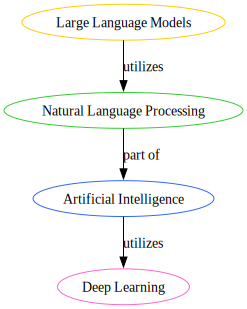

In [54]:
kg = pydantic_output_parser.parse(output_graph_json_dict)

visualize_knowledge_graph(kg)

Yaaay victory!!! Now, let's wrap this into a modified version of the original chain by using the RunnableLambda Object to do the 
intermediary step we were doing before.

Nice! How about we put everything together under a class that represents this LangChain implementation of the ADEPT method?

In [55]:
from dataclasses import dataclass
from typing import Any
from langchain_core.prompts import ChatPromptTemplate
from langchain.schema.runnable import RunnableParallel
from langchain_openai.chat_models import ChatOpenAI

@dataclass
class ADEPT:
    concept: str
    llm_chat = ChatOpenAI()
    
    def chain_analogy(self):
        return ChatPromptTemplate.from_template("Write a simple analogy for this concept: '''{concept}''', which should perfectly encapsulate\
            what it is.") | llm_chat

    
    def chain_diagram_viz(self):
        """Full chain to generate the formatted knowledge graph"""
        openai_function_knowledge_graph = convert_pydantic_to_openai_function(KnowledgeGraph) 
        llm_with_tools = llm_chat.bind(functions=[openai_function_knowledge_graph])
        pydantic_output_parser = PydanticOutputParser(pydantic_object=KnowledgeGraph)
        return ChatPromptTemplate.from_template("Write a knowledge graph with the necessary concepts and elements to understand the following concept: '''{concept}''', this diagram should perfectly encapsulate\
            what it is and what it relates to.") | llm_with_tools | RunnableLambda(lambda x: x.additional_kwargs["function_call"]["arguments"]) | pydantic_output_parser
        

    def chain_example(self):
        return ChatPromptTemplate.from_template("Write down five examples that perfectly demonstrate this concept: '''{concept}'''. ") | llm_chat


    def chain_plain_english(self):
        return ChatPromptTemplate.from_template("Write a plain english definition for this concept: '''{concept}'''") | llm_chat


    def chain_technical_definition(self):
        return ChatPromptTemplate.from_template("Write a short and precise technical definition for this concept: '''{concept}'''") | llm_chat
    
    def visualize_knowledge_graph(self, kg: KnowledgeGraph):
        dot = Digraph(comment="Knowledge Graph")

        # Add nodes
        for node in kg.nodes:
            dot.node(str(node.id), node.label, color=node.color)

        # Add edges
        for edge in kg.edges:
            dot.edge(str(edge.source), str(edge.target), label=edge.label, color=edge.color)

        # Render the graph
        display(graphviz.Source(dot.source))
        
    # now let's write a __call__ method that runs all of the chains and generates a nice output just from the concept input.
    def __call__(self):
        analogy_chain = self.chain_analogy()
        diagram_chain = self.chain_diagram_viz()
        example_chain = self.chain_example()
        plain_english_chain = self.chain_plain_english()
        technical_definition_chain = self.chain_technical_definition()
        map_chain = RunnableParallel(analogy=analogy_chain, diagram=diagram_chain, example=example_chain, 
                             plain_english=plain_english_chain, technical_def=technical_definition_chain)
        output_explanation = map_chain.invoke({"concept": self.concept})
        return output_explanation


In [56]:
concept = "artificial neural networks"

adept = ADEPT(concept)
adept

ADEPT(concept='artificial neural networks')

In [57]:
output_explanation = adept()

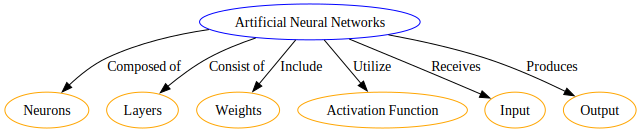

In [58]:
diagram = output_explanation["diagram"]

adept.visualize_knowledge_graph(diagram)

In [59]:
output_explanation["analogy"].content

'Artificial neural networks are like interconnected light bulbs in a string of Christmas lights - each bulb represents a neuron that is connected to others, working together to create a beautiful and complex display of patterns and information processing.'

In [60]:
output_explanation["example"].content

'1. Image recognition software that can accurately identify objects in photos using artificial neural networks.\n2. Speech recognition technology that can transcribe spoken words into text with high accuracy using artificial neural networks.\n3. Autonomous vehicles that can navigate roads and avoid obstacles using artificial neural networks.\n4. Recommender systems that can predict user preferences and make personalized recommendations using artificial neural networks.\n5. Financial fraud detection systems that can identify suspicious patterns in transactions using artificial neural networks.'

In [61]:
output_explanation["plain_english"].content

'Artificial neural networks are computer systems designed to mimic the way the human brain processes information, using interconnected nodes to learn patterns and make decisions.'

In [62]:
output_explanation["technical_def"].content

'Artificial neural networks are computational models inspired by the structure and function of biological neural networks, consisting of interconnected nodes (neurons) that process and transmit information through weighted connections.'